# Classifying Chest X-rays with Cross-Modal Data Programming

This tutorial demonstrates how to use the *cross-modal data programming* technique described in Dunnmon and Ratner, et al. (2019) to build a Convolutional Neural Network (CNN) model for chest radiograph triage with no hand-labeled training data that performs similarly to a CNN supervised using several thousand data points labeled by radiologists. 

In cross-modal data programming, we model and combine expert-provided heuristics written over an auxiliary modality (e.g. a text report), which is only available at training time, to create probabilistic labels for training a machine learning model over a target modality (e.g. a chest radiograph).  

Below, we provide a step-by-step walkthrough of how to apply this technique to a small, publicly available chest radiograph dataset.  This process is equivalent to that followed for each dataset in our 2019 submission. 

We use high-level APIs from Snorkel to support heuristic development and model training.

## Step 0: Setting Up the Environment

We begin by setting up our notebook environment and importing relevant Python packages.

In [109]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys, os
import torch
# Making sure CUDA devices are visible
os.environ['CUDA_VISIBLE_DEVICES']='0'
print(f'GPU Available? {torch.cuda.is_available()}')

# Importing pandas for data processing
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
GPU Available? True


## Step 0: Downloading Data

Run the cell below (uncommented) to download your data; only do this once!

In [110]:
#! bash data/download.sh
#! mv openi data
#! rm NLMCXR_png.tgz

## Step 1: Loading and Splitting the Data

First, we set up the data dictionary and load data that we've already split for you into an (approximately) 80% train split, 10% validation split, and 10% test split.  Each raw data point contains three fields: a text report, a label (normal or abnormal), and a set of image paths.  The original data, from the OpenI dataset, is maintained by [NIH](https://openi.nlm.nih.gov/faq.php).

In [111]:
# Setting up data dictionary and defining data splits
data = {}
splits = ['train','dev','test']

for split in splits:
    data[split] = pd.read_csv(f'data/{split}_entries.csv')[['label','xray_paths','text']]
    perc_pos = sum(data[split]['label']==1)/len(data[split])
    print(f'{len(data[split])} {split} examples: {100*perc_pos:0.1f}% Abnormal')

2630 train examples: 63.8% Abnormal
376 dev examples: 63.0% Abnormal
378 test examples: 61.6% Abnormal


You can see an example of a single data point below -- note that the raw label convention for our normal vs. abnormal classification problem is 1 for abnormal and 2 for normal.

In [112]:
# Getting a single sample from the dataframe
# Change sample_index to see different examples

sample_index = 0
sample = data['train'].iloc[sample_index]
print('RAW TEXT:\n \n',sample['text'],'\n')
print('IMAGE PATHS: \n \n', sample['xray_paths'],'\n')
print('LABEL:', sample['label'])

RAW TEXT:
 
 COMPARISON: Chest x-XXXX XXXX INDICATION: XXXX in bathtub FINDINGS: The lungs and pleural spaces show no acute abnormality. Hyperexpanded lungs. Calcified right upper lobe granuloma, unchanged. Heart size and pulmonary vascularity within normal limits. No displaced rib fractures. IMPRESSION: 1. Hyperexpansion without acute pulmonary abnormality. 

IMAGE PATHS: 
 
 ./data/openi/xrays/CXR2824_IM-1245-13001.png 

LABEL: 1


## Step 2: Developing LFs

We now define our *labeling functions* (LFs): simple, heuristic functions written by a domain expert (e.g., a radiologist) that correctly label a report as normal or abnormal with probability better than random chance.  

We give an example of all three types of LFs we reference in our paper: general pattern LFs that operate on patterns a non-expert user could easily identify, medical pattern LFs that operate on patterns easily identifiable by a clinician, and structural LFs that focus on specific structural elements of the report (e.g. how long it is) that have some correlation with the scan it describes being normal or abnormal.

In [113]:
import re
from snorkel.labeling import labeling_function

# Value to use for abstain votes
ABSTAIN = -1
# Value to use for abnormal votes
ABNORMAL = 1
# Value to use for normal votes
NORMAL = 0

# Example of a General Pattern LF
@labeling_function()
def LF_is_seen_or_noted_in_report_demo(x):
    if any(word in x.text.lower() for word in ["is seen", "noted"]):
        return ABNORMAL
    else:
        return ABSTAIN

# Example of a Medical Pattern LF
@labeling_function()
def LF_lung_hyperdistention_demo(x):
    """
    Votes abnormal for indications of lung hyperdistention.
    """
    reg_01 = re.compile("increased volume|hyperexpan|inflated", re.IGNORECASE)
    for s in x.text.split("."):
        if reg_01.search(s):
            return ABNORMAL
    ### *** ###
    return NORMAL

# Example of a Structural LF
@labeling_function()
def LF_report_is_short_demo(x):
    """
    Checks if report is short.
    """
    return NORMAL if len(x.text) < 280 else ABSTAIN

Now, we can see how well these LFs might do at correctly indicating normal or abnormal examples.  Check them out by changing the `lf_test` function in the cell below to reference one of those listed above. 

In [114]:
from snorkel.labeling import PandasLFApplier, LFAnalysis

# Testing single LF
lfs_test = [LF_lung_hyperdistention_demo]

# Computing LF outputs on dev set
applier = PandasLFApplier(lfs=lfs_test)
L_dev = applier.apply(df=data['dev'])

# Getting ground truth dev set labels
Y_dev = data['dev'].label.values

# Summarizing LF performance
LFAnalysis(L=L_dev, lfs=lfs_test).lf_summary(Y=Y_dev)

100%|██████████| 376/376 [00:00<00:00, 26530.15it/s]


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
LF_lung_hyperdistention_demo,0,"[0, 1]",1.0,0.0,0.0,168,208,0.446809


If we use analyze the `LF_lung_hyperdistention_demo` function -- in this case,  we see that it has polarity [1,2], meaning it votes on both class 1 and class 2 (and votes on every example because `coverage` = 1.0), but that it has low accuracy (around 44%).  Let's look at the confusion matrix to see why. 

In [115]:
from utils import confusion_matrix

# HACK: API DOESN'T HAVE NICE PRINTING ANY MORE?

# Print confusion matrix
conf = confusion_matrix(Y_dev, L_dev[0:])

        y=0    y=1   
 l=0    136    205   
 l=1     3     32    


Clearly, this LF is much more accurate on abnormal examples (where y=1) than on normal examples (where y=2).  Why don't we adjust it to only vote in the positive direction and see how we do?  

Go ahead and change `NORMAL` to `ABSTAIN` in the `LF_lung_hyperdistention_demo` function (the line below the `### *** ###` comment), and rerun the last three code cells.  

You'll see that by making this rule a bit more targeted, its coverage decreases to 9%, but it's accuracy jumps to over 90%.  This type of iteration is exactly how clinicians can develop LFs in practice.

You may also notice that it's very easy to write these LFs over text, but it would be very hard to, say, write an `LF_lung_hyperdistention` version that operates over an image -- this is why cross-modality is so important!

## Step 3: Computing the Label Matrix

Once we've designed a couple of LFs, it's time to execute them all on every example we have to create a *label matrix*.  This is an $n$ by $m$ matrix, where $n$ is the number of examples and $m$ is the number of LFs.  

Below, we've provided more LFs to give you a sense of a what a real application would look like -- code for these can be found in the `labeling_functions.py` file in this directory.

In [116]:
from labeling_functions import *

lfs = [
    LF_report_is_short,
    LF_consistency_in_report,
    LF_negative_inflection_words_in_report,
    LF_is_seen_or_noted_in_report,
    LF_disease_in_report,
    LF_abnormal_mesh_terms_in_report,
    LF_recommend_in_report,
    LF_mm_in_report,
    LF_normal,
    LF_positive_MeshTerm,
    LF_fracture,
    LF_calcinosis,
    LF_degen_spine,
    LF_lung_hypoinflation,
    LF_lung_hyperdistention,
    LF_catheters,
    LF_surgical,
    LF_granuloma,
]

Now, we simply apply each of our LFs to each of our reports.

In [117]:
# Allocating label matrix and ground truth label lists
Ls = {}
Ys = {}

# Computing lfs
print('Computing label matrices and creating ground truth label vectors...')
applier = PandasLFApplier(lfs=lfs)

for split in ['train','dev','test']:
    Ls[split] = applier.apply(df=data[split])
    Ys[split] = data[split].label.values

  6%|▌         | 156/2630 [00:00<00:01, 1556.37it/s]

Computing label matrices and creating ground truth label vectors...


100%|██████████| 378/378 [00:00<00:00, 1960.67it/s]


Now that we've done this, we can inspect our accuracy on the development set and other useful LF metrics using the simple Snorkel interface.

In [118]:
# Summarizing LF performance
LFAnalysis(L=Ls['dev'], lfs=lfs).lf_summary(Y=Y_dev)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
LF_report_is_short,0,[0],0.303191,0.303191,0.196809,72,42,0.631579
LF_consistency_in_report,1,"[0, 1]",1.000000,0.928191,0.476064,269,107,0.715426
LF_negative_inflection_words_in_report,2,[1],0.082447,0.082447,0.039894,30,1,0.967742
LF_is_seen_or_noted_in_report,3,[1],0.085106,0.085106,0.034574,25,7,0.781250
LF_disease_in_report,4,[1],0.372340,0.372340,0.234043,89,51,0.635714
LF_abnormal_mesh_terms_in_report,5,[1],0.417553,0.417553,0.204787,141,16,0.898089
LF_recommend_in_report,6,[1],0.015957,0.015957,0.002660,6,0,1.000000
LF_mm_in_report,7,[1],0.053191,0.053191,0.010638,20,0,1.000000
LF_normal,8,[0],0.159574,0.159574,0.082447,34,26,0.566667
LF_positive_MeshTerm,9,[1],0.295213,0.295213,0.143617,108,3,0.972973


Note that all of our labeling functions, while certainly imperfect, are better than random chance.  This fulfills the only theoretical requirement of the cross-modal data programming algorithm.  

We can also get a sense of where the LFs overlap and conflict by inspecting the following plot; it is useful that some of the LFs overlap or conflict, as this provides signal that allows us to learn their accuracies.

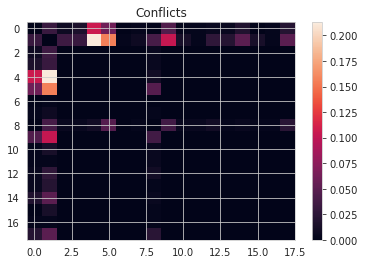

In [119]:
from utils import view_conflicts

# HACK: WHY IS THIS DIFFERENT THAN BEFORE? CHECK INDEXING
# Viewing conflicts
view_conflicts(Ls['dev'], normalize=True)

## Step 4: Train a Label Model in Snorkel

Next, we use the Snorkel MeTaL model training API (imported as `metal`) to train a generative model that learns the accuracies of our LFs.  By combining our labeling functions based on their accuracies, we can recover a model that outputs higher quality
weak labels.

We perform a simple random hyperparameter search over learning rate and L2 regularization, using our small labeled development set to choose the best model.  

In [120]:
from snorkel.labeling import LabelModel
import warnings
warnings.filterwarnings('ignore')

# HACK: NO VERBOSE TRAINING ANYMORE?

gm = LabelModel(cardinality=2, verbose=True)
gm.fit(L_train=Ls['train'], n_epochs=10000, lr=0.01, log_freq=100, seed=123)

We evaluate our best model on the development set as below -- you should recover a model with best accuracy of approximately 85% on the development set.

In [121]:
# GM SCORING CELL
# Getting scores
scores = gm.score(Ls['dev'], Y=Ys['dev'], metrics=['accuracy','precision', 'recall', 'f1','roc_auc'])
print("Generative Model Scores")
_ = [print(f"{k} : {v*100:.1f}%") for (k,v) in scores.items()]

Generative Model Scores
accuracy : 87.2%
precision : 92.4%
recall : 86.9%
f1 : 89.6%
roc_auc : 93.4%


Why is this useful?  If we compare to majority vote, we see a couple points of improvement in accuracy.  Note that the degree to which we expect this model to improve over majority vote varies based on the type of dataset involved, as detailed in the 2017 [VLDB Paper](http://www.vldb.org/pvldb/vol11/p269-ratner.pdf) describing the Snorkel system.

In [122]:
from snorkel.labeling import MajorityLabelVoter

majority_model = MajorityLabelVoter()
preds_train = majority_model.predict(L=Ls['train'])

# Checking if we beat majority vote
mv = MajorityLabelVoter()
scores = mv.score(Ls['dev'], Y=Ys['dev'], metrics=['accuracy','precision', 'recall', 'f1','roc_auc'])
print("Majority Vote Scores")
_ = [print(f"{k} : {v*100:.1f}%") for (k,v) in scores.items()]

Majority Vote Scores
accuracy : 87.1%
precision : 93.7%
recall : 85.6%
f1 : 89.5%
roc_auc : 87.7%


## Step 5: Apply Heuristic Optimizer for LSTM Training

We now apply the cross-modal data programming heuristic optimizer to determine whether or not to train an LSTM mapping the raw report text to the generative model output.  We can train a text model (as in the spam example) to directly map our raw text to the generative model output if either our (a) coverage or (b) ROC-AUC is low.  Heuristically, we often train such a model using standard tools from PyTorch in cases where either coverage or ROC-AUC of the generative model on the development set is less than 90%.  

For this example, our coverage is 100%, and generative model (`gm`) ROC-AUC should be around 92% on the development set (see cell above with comment `GM SCORING CELL`).  Thus, we forego training the LSTM, and use our generative model directly to provide weak labels for our target modality model.

## Step 6: Create a Weakly Labeled Training Set

We can now use this trained generative model to create weak labels for each of our train, development, and test splits by applying it to the label matrices, as below. 

In [123]:
Y_ps = {}
Y_preds = {}
for split in ['train','dev','test']:
    Y_ps[split] = gm.predict_proba(Ls[split])
    Y_preds[split] = gm.predict(Ls[split])

We can inspect the distribution of our weak training labels, and note that they are assigned varying degrees of probability.  An advantage of this labeling approach is that probabilistic labels can be very descriptive -- i.e., if an example has a 60% probability of being abnormal, we train against that 0.6 probability, rather than binarizing to 100%.  

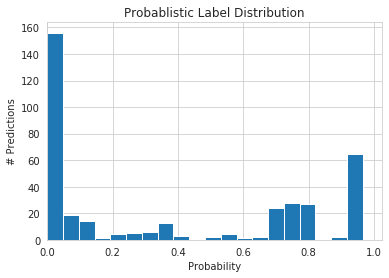

In [124]:
from utils import plot_probabilities_histogram

# Looking at probability histogram for training labels
plot_probabilities_histogram(Y_ps['dev'][:,0], title="Probablistic Label Distribution")

Using the development set, we can also check that the class balance of our weak labels if we were to naively binarize at the 0.5 cutoff -- we see reasonable behavior here.

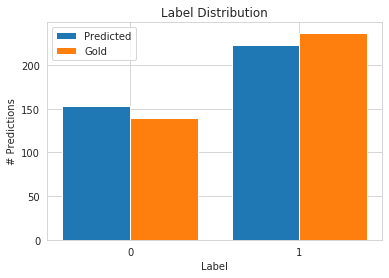

In [125]:
from utils import plot_predictions_histogram
# Obtaining binarized predictions
Y_dev_p = gm.predict(Ls['dev'])
plot_predictions_histogram(Y_preds['dev'], Ys['dev'], title="Label Distribution")

## Step 7 [SNORKEL VERSION]: Train a Weakly Supervised Target Modality Model

Now that we have our weak training labels, we can train a commodity CNN using the high-level PyTorch API From Snorkel MeTaL.  The entire process of defining and training the model can be executed in the following two simple cells.

First, we define PyTorch `DataLoader` objects to efficiently load our image data, associating each image with the weak label generated from its associated report.

In [127]:
import torch
from torchvision import models
from utils import get_data_loader, create_model

# Create pytorch model
num_classes = 2
cnn_model = models.resnet50(pretrained=True)
weakly_supervised_model = create_model(cnn_model, num_classes)

# Create data loaders
loaders = {}
for split in ['train', 'dev', 'test']:
    labs = Y_ps[split] if split == 'train' else Ys[split]
    loaders[split] = get_data_loader(data[split]['xray_paths'].tolist(), labs, split=split, batch_size=32, shuffle=True)

As an example, a single datapoint yields an image like this:

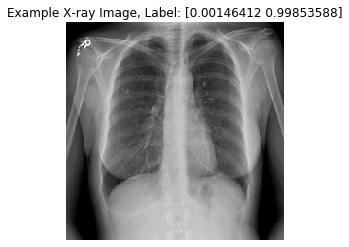

In [53]:
import matplotlib.pyplot as plt
img, label = loaders['train'].dataset[0][0]['xray'], loaders['train'].dataset[0][1]['openi_task']

plt.figure()
plt.imshow(img[0,:,:],cmap='gray')
plt.title(f'Example X-ray Image, Label: {label.numpy()}')
ax = plt.axis('off')

Now that our `DataLoaders` are set up, it is a simple matter to define and train our CNN model. 

Note: While this will run if you do not have a CUDA-based GPU available (and will automatically detect it if you do), it will proceed *much* faster if you have one!  CPU-only per-epoch training time is ~ 15 minutes, while with a Titan X it is approximately 30 s!

In [55]:
from snorkel.classification import Trainer

trainer = Trainer(
    n_epochs=5,  # increase for improved performance
    lr=1e-4,
    l2=1e-5,
    checkpointing=True,
    checkpointer_config={"checkpoint_dir": "checkpoint", "checkpoint_metric":"openi_task/valid/valid/f1:max"},
)
trainer.fit(weakly_supervised_model, [loaders['train'], loaders['dev'], loaders['test']])

Epoch 4:: 100%|██████████| 83/83 [00:26<00:00,  3.09it/s, model/all/train/loss=0.356, model/all/train/lr=0.0001, openi_task/valid/valid/accuracy=0.691, openi_task/valid/valid/precision=0.686, openi_task/valid/valid/recall=0.941, openi_task/valid/valid/f1=0.794, openi_task/valid/valid/roc_auc=0.728]


We can evaluate this model below, and see that we've learned some useful signal!  Remember that an Area Under the Receiver Operating Characteristic (ROC-AUC) score represents the probability across all possible cutoffs of ranking an abnormal example higher than a normal example.  If we've learned nothing useful, this value would be 0.5. 

You should expect a value above 0.70 for this training run.

In [56]:
# Evaluating model
print (f"Evaluating Weakly Supervised Model")
scores = weakly_supervised_model.score(
    [loaders['test']]
)
print("Weakly Supervised Scores")
_ = [print(f"{k} : {v*100:.1f}%") for (k,v) in scores.items()]

Evaluating Weakly Supervised Model
Weakly Supervised Scores
openi_task/test/test/accuracy : 68.0%
openi_task/test/test/precision : 67.3%
openi_task/test/test/recall : 93.6%
openi_task/test/test/f1 : 78.3%
openi_task/test/test/roc_auc : 71.5%


## Step 8 [SNORKEL VERSION]: Comparing to a Fully Supervised Target Modality Model

Because we have ground-truth labels for the entire dataset in this case (the OpenI dataset comes with these labels, which require physicians to label thousands of images!), we can compare how well our weakly supervised target modality model does with the performance we achieve from a fully supervised model.

Executing this requires a simple change to the training dataloader to provide it with ground-truth labels.

In [57]:
from snorkel.utils.core import preds_to_probs
fully_supervised_model = create_model(cnn_model, num_classes)

# Replace training loader with fully supervised version
loaders['train'] = get_data_loader(data['train']['xray_paths'].tolist(), preds_to_probs(Ys['train'], num_classes=2), split='train', batch_size=32, shuffle=True)

# Training fully supervised model
trainer.fit(fully_supervised_model, [loaders['train'], loaders['dev'], loaders['test']])

Epoch 4:: 100%|██████████| 83/83 [00:26<00:00,  3.10it/s, model/all/train/loss=0.0754, model/all/train/lr=0.0001, openi_task/valid/valid/accuracy=0.726, openi_task/valid/valid/precision=0.766, openi_task/valid/valid/recall=0.814, openi_task/valid/valid/f1=0.789, openi_task/valid/valid/roc_auc=0.744]


Now, we can evaluate the weakly and fully supervised models.  

In [58]:
# Evaluating weakly model
print (f"Evaluating Weakly Supervised Model")
weakly_supervised_scores = weakly_supervised_model.score(
    [loaders['test']]
)
_ = [print(f"{k.split('/')[-1]} : {v*100:.1f}%") for (k,v) in weakly_supervised_scores.items() if 'roc_auc' in k]

# Evaluating fully supervised model
print (f"Evaluating Fully Supervised Model")
fully_supervised_scores = fully_supervised_model.score(
    [loaders['test']]
)
_ = [print(f"{k.split('/')[-1]} : {v*100:.1f}%") for (k,v) in fully_supervised_scores.items() if 'roc_auc' in k]

Evaluating Weakly Supervised Model
roc_auc : 75.9%
Evaluating Fully Supervised Model
roc_auc : 76.0%


If the models have trained successfully, you should observe that the weakly and fully supervised models both achieve ROC-AUC scores around 0.70-0.75.  This indicates that the weak labels we created using our labeling functions over the text have successfully allowed us to train a CNN model that performs similarly to one trained using ground truth, but *without having to label thousands of images*.  

Further, we would expect the performance of the weakly supervised model to improve as more *unlabeled* data is added to this relatively small dataset!

Congratulations! You've just trained a deep learning model using cross-modal data programming! 